<a href="https://colab.research.google.com/github/Christian-Stefan/Team-Internship/blob/Chris/ContextModel.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Data Preparation

## Data Curation

In [ ]:
# 1. Importing Data.csv
data = pd.read_csv('Data.csv')


# 2. Eliminating CTs which have no nodule slices
data["slices_present"] = data["slices_present"].apply(
    lambda x: ast.literal_eval(x) if isinstance(x, str) else x
)
data = data[data['slices_present'].apply(lambda x: len(x) > 0)]
print((data['slices_present'].apply(len) == 0).sum()) # No zero-slices CTs
print(len(data)) # The number of fields slightly decreased

0
1453


## Encoding Labels

In [ ]:
# 3. Encoding labels
label = LabelEncoder()
data['label'] = label.fit_transform(data['nodule_name'])
label_map = dict(zip(label.classes_, label.transform(label.classes_)))
print(label_map)

{'Active Infection': np.int64(0), 'Adenocarcinoma': np.int64(1), 'Adenoid Cystic Carcinoma': np.int64(2), 'Bronchioloalveolar Hyperplasia': np.int64(3), 'Carcinoid Tumors': np.int64(4), 'Granuloma': np.int64(5), 'Hamartoma': np.int64(6), 'Intrapulmonary Lymph Nodes': np.int64(7), 'Large Cell (Undifferentiated) Carcinoma': np.int64(8), 'Lymphoma': np.int64(9), 'Metastatic Tumors': np.int64(10), 'Sarcoidosis': np.int64(11), 'Sarcomatoid Carcinoma': np.int64(12), 'Small Cell Lung Cancer (SCLC)': np.int64(13), 'Squamous Cell Carcinoma': np.int64(14)}


## Volume input preprocessing and construction

Image size: (512, 512) 
Image type <class 'numpy.ndarray'>
Image size: (224, 224, 1) 
Image type <class 'numpy.ndarray'>,
 Normalized: (np.float32(1.0), np.float32(0.0))


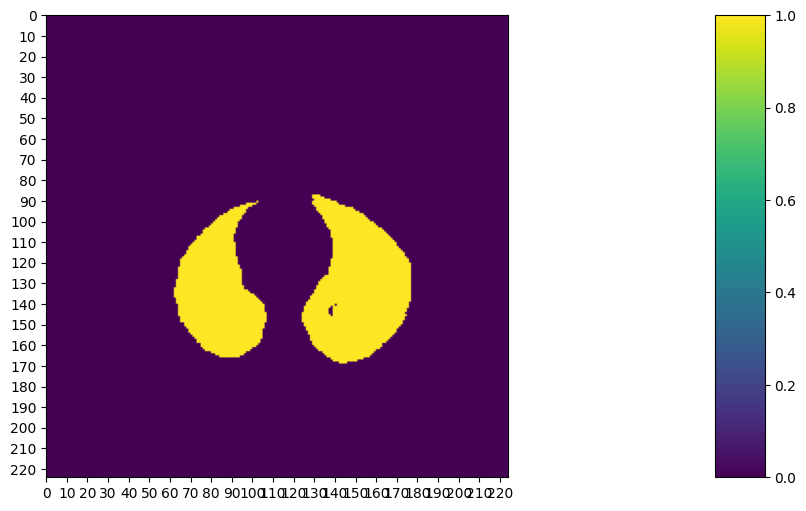

{'img': array([[[0.],
        [0.],
        [0.],
        ...,
        [0.],
        [0.],
        [0.]],

       [[0.],
        [0.],
        [0.],
        ...,
        [0.],
        [0.],
        [0.]],

       [[0.],
        [0.],
        [0.],
        ...,
        [0.],
        [0.],
        [0.]],

       ...,

       [[0.],
        [0.],
        [0.],
        ...,
        [0.],
        [0.],
        [0.]],

       [[0.],
        [0.],
        [0.],
        ...,
        [0.],
        [0.],
        [0.]],

       [[0.],
        [0.],
        [0.],
        ...,
        [0.],
        [0.],
        [0.]]], dtype=float32), 'label': 'Small Cell Lung Cancer (SCLC)'}


In [73]:
from drive.MyDrive.TeamInternship.P_P import Preprocessing

# 4. Preprocess lungs
# processing = Preprocessing(Root_path="/content/drive/MyDrive/TeamInternship/20241221_074106",
#                          Output_path="/content/Output")
# dcm_collected_data = processing.get_slice_and_coordnates_Paths()

# processing.preprocess_Data(dcm_collected_data,
#                            plot=False,
#                            save=True,
#                            segment=False)

# 5. Initialize the sitk class - ImageSeriesReader - to create suitable objects for lung's slices and labels
sample_path:str = '/content/Output/LIDC-IDRI-0000/LungLIDC-IDRI-0000_1-0053.dcm'
dicom_files = pydicom.dcmread(sample_path)
img_context = dicom_files.pixel_array
print("Image size:",img_context.shape,f"\nImage type {type(img_context)}")

resized_image = cv2.resize(img_context, (224,224)) # 5.1. Resizing the image
normalized_image  = resized_image.astype(np.float32) # 5.2. Normalization
normalized_image = (normalized_image - normalized_image.min()) / (normalized_image.max() - normalized_image.min() + 1e-5)
channeled_image = np.expand_dims(normalized_image,-1) # 5.3. Adding one more channel - binary

print("Image size:",channeled_image.shape,f"\nImage type {type(channeled_image)},\n Normalized: {channeled_image.max(), channeled_image.min()}")

fig = plt.figure(figsize=(10,6))
plt.imshow(resized_image)
plt.xticks(np.arange(-0.5, normalized_image.shape[0]+1, 10), labels=np.arange(0, normalized_image.shape[0]+1, 10))
plt.yticks(np.arange(-0.5, normalized_image.shape[1]+1, 10), labels=np.arange(0, normalized_image.shape[1]+1, 10))
plt.clim([0,1])
cbar_ax = fig.add_axes([0.95, .11, 0.05, 0.77])
plt.clim([0, 1])
plt.colorbar(cax=cbar_ax)
plt.show()

# 6. Craft a dictionary that can encompass both, the image itself and associated label: {'img': numpy.ndarray, 'label': ...}
import json
json_path:str = "/content/Output/LIDC-IDRI-0000/segmentation_00000.json"
with open(json_path, 'r') as f:
  json_annotation = json.load(f)

label = json_annotation['characteristics'][0]['nodule_name']
prepared_sample = {'img':channeled_image,'label':label}

print(prepared_sample)

## ViT Initialization

In [41]:
# 0. Pre-configurations necessary to conveniently `normalize` (e.g. resize) the image to be suitable for a transformer
from transformers import ViTFeatureExtractor
model_name = 'google/vit-base-patch16-224-in21k' # import model
feature_extractor = ViTFeatureExtractor.from_pretrained(model_name)

feature_extractor

/usr/local/lib/python3.11/dist-packages/transformers/models/vit/feature_extraction_vit.py:28: FutureWarning: The class ViTFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use ViTImageProcessor instead.
  warnings.warn(


ViTFeatureExtractor {
  "do_convert_rgb": null,
  "do_normalize": true,
  "do_rescale": true,
  "do_resize": true,
  "image_mean": [
    0.5,
    0.5,
    0.5
  ],
  "image_processor_type": "ViTFeatureExtractor",
  "image_std": [
    0.5,
    0.5,
    0.5
  ],
  "resample": 2,
  "rescale_factor": 0.00392156862745098,
  "size": {
    "height": 224,
    "width": 224
  }
}

There will be 49 patches, each 32 by 32.




IndexError: index 21 is out of bounds for axis 0 with size 21

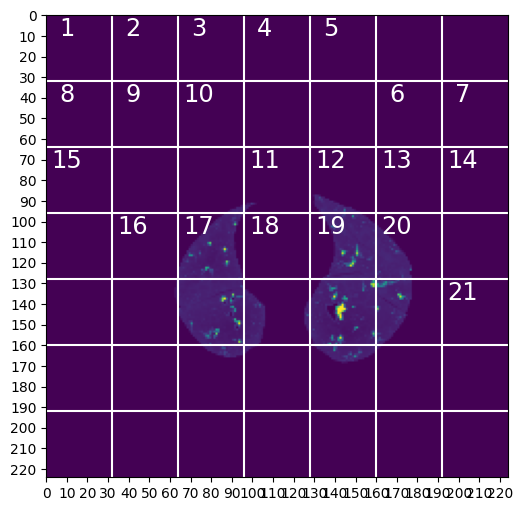

In [99]:

# example = feature_extractor(prepared_sample['img'], return_tensor='pt')
# example
# ---> This caused an error as only one channel is used which is not supported by feature_extractor


# 0. Transform the image into a tensor

# 1. Transform an image into patches;
P = 32 # Pixel-Size for each patch
N = int((prepared_sample['img'].shape[0]*prepared_sample['img'].shape[1])/(P**2))
print('There will be', N, 'patches, each', P, 'by', str(P)+'.')
print('\n')

fig = plt.figure(figsize=(13,6))
plt.imshow(prepared_sample['img'])
plt.hlines(np.arange(P, prepared_sample['img'].shape[0], P)-0.5, -0.5, prepared_sample['img'].shape[1]-0.5, color='w')
plt.vlines(np.arange(P, prepared_sample['img'].shape[1], P)-0.5, -0.5, prepared_sample['img'].shape[0]-0.5, color='w')
plt.xticks(np.arange(-0.5, prepared_sample['img'].shape[1]+1, 10), labels=np.arange(0, prepared_sample['img'].shape[1]+1, 10))
plt.yticks(np.arange(-0.5, prepared_sample['img'].shape[0]+1, 10), labels=np.arange(0, prepared_sample['img'].shape[0]+1, 10))
x_text = np.tile(np.arange(9.5, prepared_sample['img'].shape[1], P), 3)
y_text = np.repeat(np.arange(9.5, prepared_sample['img'].shape[0], P), 5)
for i in range(1, N+1):
    plt.text(x_text[i-1], y_text[i-1], str(i), color='w', fontsize='xx-large', ha='center')
plt.text(x_text[2], y_text[2], str(3), color='k', fontsize='xx-large', ha='center');

In [101]:
class Patch_Tokenization(nn.Module):
  def __init__(self,
               img_size: tuple[int, int, int]=(1,1,224,224),
               patch_size:int = 50,
               token_len: int = 2500):

    """
      Patch Tokenization Module
            Args:
                img_size (tuple[int, int, int]): size of input (channels, height, width)
                patch_size (int): the side length of a square patch
                token_len (int): desired length of an output token
    """
    super().__init__()

    ## Defining Parameters
    self.img_size = img_size
    C, H, W = self.img_size
    self.patch_size = patch_size
    self.token_len = token_len

    # Testing the distribution to be evenly spaced
    assert H % self.patch_size == 0, 'Height of image must be evenly divisible by patch size.'
    assert W % self.patch_size == 0, 'Width of image must be evenly divisible by patch size.'

    ## Definining Layers
    self.split = nn.Unfold(kernel_size=self.patch_size,
                           stride=self.patch_size,
                           padding=0)
    self.project = nn.Linear((self.patch_size**2)*C, token_len)

    def forward(self,x):
      x = self.split(x).transpose(1,0)
      x = self.project(x)

      return x

### Example ###
x = torch.tensor(prepared_sample['img']).permute(2,0,1).unsqueeze(0).float()
token_len = 2500
print('Input dimensions are\n\tbatchsize:', x.shape[0], '\n\tnumber of input channels:', x.shape[1], '\n\timage size:', (x.shape[2], x.shape[3]))

### Trying to tokenize ###
patch_tokens = Patch_Tokenization(img_size=(x.shape[1], x.shape[2], x.shape[3]),
                                    patch_size = P,
                                    token_len = token_len)

### Displaying new-array dimensions after tokenization ###
x = patch_tokens.split(x).transpose(2,1)
print('After patch tokenization, dimensions are\n\tbatchsize:', x.shape[0], '\n\tnumber of tokens:', x.shape[1], '\n\ttoken length:', x.shape[2])

Input dimensions are
	batchsize: 1 
	number of input channels: 1 
	image size: (224, 224)
After patch tokenization, dimensions are
	batchsize: 1 
	number of tokens: 49 
	token length: 1024


In [89]:
# 2. Linear Projection Layer - mapping arrays to vectors to match  the correct dimensionality;

# 3. Learnable embedding/Classifier token;

# 4. Poition paddings - tracking the position of input mechanism is yet to be established before this step;

# Fusion Model

## Context Branch

In [ ]:
class ContextBranch(nn.Module):
    def __init__(self):
        super().__init__() # Constructor to initialize the `upper` constructor/pervious constructor? Why?
        self.conv = nn.Sequential(
            nn.Conv3d(1, 16, kernel_size=3, padding=1),
            nn.BatchNorm3d(16),
            nn.ReLU(),
            nn.MaxPool3d(2),  # (7,256,256) → (3,128,128)

            nn.Conv3d(16, 32, kernel_size=3, padding=1),
            nn.BatchNorm3d(32),
            nn.ReLU(),
            nn.AdaptiveAvgPool3d((1, 1, 1))  # output: [B, 32, 1, 1, 1]
        )

    def forward(self, x):
        x = self.conv(x)
        return x.view(x.size(0), -1)  # [B, 32]

## Radiomics Branch

In [ ]:
class RadiomicsBranch(nn.Module):
    def __init__(self, input_dim):
        super().__init__()
        self.fc = nn.Sequential(
            nn.Linear(input_dim, 64),
            nn.ReLU(),
            nn.Linear(64, 32)
        )

    def forward(self, x):
        return self.fc(x)

## Local Branch

In [ ]:
class LocalBranch(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv3d(1, 16, kernel_size=3, padding=1),
            nn.BatchNorm3d(16),
            nn.ReLU(),
            nn.MaxPool3d(2),  # (5,64,64) → (2,32,32)

            nn.Conv3d(16, 32, kernel_size=3, padding=1),
            nn.BatchNorm3d(32),
            nn.ReLU(),
            nn.AdaptiveAvgPool3d((1, 1, 1))  # output: [B, 32, 1, 1, 1]
        )

    def forward(self, x):
        x = self.conv(x)
        return x.view(x.size(0), -1)  # flatten to [B, 32]

# Model Header

In [ ]:
class TripleFusionModel(nn.Module):
    def __init__(self, num_classes, radiomics_dim=25):
        self.local_branch = LocalBranch()
        self.context_branch = ContextBranch()
        self.radiomics_branch = RadiomicsBranch(radiomics_dim)

        self.classifier = nn.Sequential(
            nn.Linear(32 + 32 + 32, 64),  # fuse outputs
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(64, num_classes)
        )

    def forward(self, volume_local, volume_context, radiomics):
        local_feat = self.local_branch(volume_local)
        context_feat = self.context_branch(volume_context)
        radio_feat = self.radiomics_branch(radiomics)

        fused = torch.cat([local_feat, context_feat, radio_feat], dim=1)
        out = self.classifier(fused)
        return out

# Model Selection

## Particle Swarm Optimization (PSO) - Hyperparameter Optimization Initialization & Explanation

In Particle Swarm Optimization (PSO), **particles** represent candidate solutions—for example, a randomly initialized set of hyperparameters for a machine learning model.

- Each particle moves within a **D-dimensional bounded continuous search space**.
- Particles collaborate to discover the optimal solution (i.e., the hyperparameter combination that minimizes a loss function).

Each particle \( i \) is defined by three key vectors at each iteration \( t \):

- **Position**: $\mathbf{x}_i(t) \in \mathbb{R}^D $ — current location of particle \( i \)
- **Velocity**: $mathbf{v}_i(t) \in \mathbb{R}^D $ — the movement direction and speed of particle \( i \)
- **Best Position**: $ \mathbf{b}_i(t) \in \mathbb{R}^D $— the best position found so far by particle \( i \) based on the fitness (e.g., validation loss)

### Position Update Rule

The new position is computed by adding the current velocity to the current position:

\[
$\mathbf{x}_i(t + 1) = \mathbf{x}_i(t) + \mathbf{v}_i(t)$
\]

### Velocity Update Rule (Conceptual Overview)

The velocity is influenced by:
- **Cognitive component**: Particle's own best-known position
- **Social component**: Best-known position among all particles (global best)

The combination of these two attractions causes particles to explore and exploit the search space, ideally converging on an optimal or near-optimal solution over iterations.


In [ ]:
import random as rd

best_position_container:list = [] # Keeps track of best position g(t) visited by any particple up to itteration t

# 1. Random initialization of particles/subsets of variants for hyperparameters (e.g., Learning Rate;	Optimizer; Loss Functios)
up_lr:float = 0.1 # Upper range of learning rate - initially
low_lr:float = 0.01 # Lower range of learning rate

optimizers:list = [ # Available optimizers in torch
    "Adadelta",
    "Adafactor",
    "Adagrad",
    "Adam",
    "AdamW",
    "SparseAdam",
    "Adamax",
    "ASGD",
    "LBFGS",
    "NAdam",
    "RAdam",
    "RMSprop",
    "Rprop",
    "SGD"
]

loss_functions:list = [
    "L1Loss",
    "MSELoss",
    "CrossEntropyLoss",
    "CTCLoss",
    "NLLLoss",
    "PoissonNLLLoss",
    "GaussianNLLLoss",
    "KLDivLoss",
    "BCELoss",
    "BCEWithLogitsLoss",
    "MarginRankingLoss",
    "HingeEmbeddingLoss",
    "MultiLabelMarginLoss",
    "HuberLoss",
    "SmoothL1Loss",
    "SoftMarginLoss",
    "MultiLabelSoftMarginLoss",
    "CosineEmbeddingLoss",
    "MultiMarginLoss",
    "TripletMarginLoss",
    "TripletMarginWithDistanceLoss"
]


hyperparameters_grid:dict = {
    'Learning_rate': [0.1, 0.01, 0.005, 0.0010, 0.00020], # rd.uniform(low_lr, up_lr),
    'Optimizer': optimizers, # optimizers[rd.randint(0, len(optimizers)-1)],
    'Loss Function': loss_functions # loss_functions[rd.randint(0, len(loss_functions)-1)]
}

### Particle initialization/estimator - Method

In [ ]:
def _init_Populaton():

  hyperparameters_grid:dict = {
    'Learning_rate': [0.1, 0.01, 0.005, 0.0010, 0.00020],
    'Optimizer': optimizers,
    'Loss Function': loss_functions
}
  return hyperparameters_grid

# Usage example - Initialize a population of 10 particles/individuals:
# for x in range(10):
#     particle = init_Populaton()
#     print(particle)

### Evaluate fitness - Method

In [ ]:
def evaluate_fitness(self,
                     X_train,
                     X_test,
                     y_train,
                     y_test,
                     hyperparameters):
        """
        Evaluate the fitness of a set of hyperparameters.

        Parameters:
            - estimator: The estimator object.
            - X_train: Training features.
            - X_test: Testing features.
            - y_train: Training labels.
            - y_test: Testing labels.
            - hyperparameters: The set of hyperparameters to evaluate.

        Returns:
            - score: The accuracy score of the estimator with the given hyperparameters.
        """
        # Unpack hyperparameters
        estimator_instance = self._create_estimator(hyperparameters)

        estimator_instance.fit(X_train, y_train)
        y_pred = estimator_instance.predict(X_test)
        accuracy_pso = accuracy_score(y_test, y_pred)
        return accuracy_pso

### Create the searching space - Method

In [ ]:
def pso_hyperparameter_optimization(self,
                                    X_train,
                                    X_test,
                                    y_train,
                                    y_test,
                                    num_particles,
                                    num_iterations,
                                    c1 = 2.05,
                                    c2 = 2.05,
                                    num_jobs=-1,
                                    w=0.72984):
        """
        Perform hyperparameter optimization using Particle Swarm Optimization (PSO).

        Parameters:
            - estimator: The estimator object (e.g., KNeighborsClassifier, ViT).
            - data: The dataset.
            - target_column_index: Index of the target column in the dataset.
            - num_particles: Number of particles in the population.
            - num_iterations: Number of iterations for the PSO algorithm.
            - c1: Acceleration constant. Default value is c1 = 2.05
            - c2: Acceleration constant. Default value is c2 = 2.05
            - num_jobs: Number of parallel jobs for fitness evaluation.
            - inertia weight: Inertia constant. Default value is w=0.72984 according to the paper by M. Clerc and J. Kennedy

        Returns:
            - global_best_position: The best set of hyperparameters found.
            - global_best_fitness: The best accuracy found.
        """
        if self.random_seed is not None:
            np.random.seed(self.random_seed)

        # 1. Initialize the population of particles
        hyperparameter_space = self._init_Populaton()
        progress_bar = tqdm(total=num_iterations, desc="PSO Progress")
        population:list = [] # Container 1: Population

        for _ in range(self.num_particles):
            hyperparameters = [np.random.choice(hyperparameter_space[param]) for param in hyperparameter_space]
            population.append(hyperparameters)


        # 2. Initialize velocity and best position
        velocity = [[0] * len(hyperparameter_space) for _ in range(num_particles)] # Container 2: Velocity, of each hyperparameter-set stays zero at initialization phase
        best_position = population.copy() # Container 3: Best position do not differ from population
        global_best_fitness = -float("inf") # Conainer 4: Best positions are all the same across individuals hence fitness stays constant
        global_best_position = [] # Container 5: Best position a given individual has ever reached




        # PSO optimization loop
        for _ in range(num_iterations):
            fitness = Parallel(n_jobs=num_jobs)(
                delayed(self.evaluate_fitness)(X_train, X_test, y_train, y_test, particle)
                for particle in population
            )





# Dependencies

In [92]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import random
import numpy as np
from tqdm import tqdm
from joblib import Parallel, delayed
from sklearn.metrics import accuracy_score, classification_report, precision_score
import pandas as pd
import ast
from sklearn.preprocessing import LabelEncoder
import SimpleITK as sitk
import time as t
import numpy as np
import matplotlib.pyplot as plt
import json, glob, re, os, pydicom
from skimage.draw import polygon
from skimage.filters import threshold_otsu
from skimage.morphology import disk
from scipy.ndimage import binary_fill_holes,label,binary_dilation,binary_erosion, binary_closing
from ipywidgets import interact
import cv2
import shutil

# !pip install pydicom
# !pip install SimpleITK